In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
from __future__ import unicode_literals

import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib notebook

In [2]:
try:
    import seaborn as sns
    sns.set()
    sns.set_style("whitegrid")
    sns.set_context("poster")
except ImportError as e:
    print("Cannot import seaborn.")
    print("Consider installing it for nice plot !")

mpl.rcParams['figure.figsize'] = [12.0, 9.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 22
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'


# Introduction


When particles collide inside the LHC, billions sub-particles are produced in all directions. The tracking detector measures the energy deposited by these sub-particle when hitting the detector material. So for each particles traversing the detector we get its impact points (10 points on average). 

The challenge is to reconstruct the particles trajectories from these 3D points.



## Load data

In [3]:
from dataset import load_hits

In [8]:
data_path = "/data/titanic_3/users/vestrade/seattle_trackml/training/"


In [9]:
data = load_hits(data_path)
data.head()

,hit_id,volume_id,layer_id,module_id,x,y,z,ncells,pixels,event_id
0,1,0,0,0,888.311,516.677000,-824.216,13,"[[284, 0, 0.094691], [285, 0, 0.154684], [286,...",50
1,2,0,0,0,-307.926,716.276000,-515.216,12,"[[284, 0, 0.0148767], [285, 0, 0.136159], [286...",50
2,3,0,0,0,-730.339,265.437000,309.124,5,"[[146, 0, 0.124591], [147, 0, 0.194279], [148,...",50
3,4,0,0,0,543.024,-559.146000,308.812,6,"[[276, 0, 0.190713], [277, 0, 0.213442], [278,...",50
4,5,0,0,0,-783.119,0.588065,-411.579,2,"[[25, 0, 0.368204], [24, 0, 0.379336]]",50


# Pre-Clustering : Dividing the 3D space  of one event

This step divides the dataset into N_pre_cluster regions. The pre-clustering is done with K-means

In [10]:
from sklearn.cluster import KMeans


In [11]:
data['r'] = np.hypot(data['x'], data['y'])


In [15]:
N_pre_cluster = 5  #Less than 5 pre-clusters will crash the agglomerative clustering

pre_labels = KMeans(n_clusters=N_pre_cluster).fit_predict(list(data[["r","z"]].values))


## Visualizing the divided space

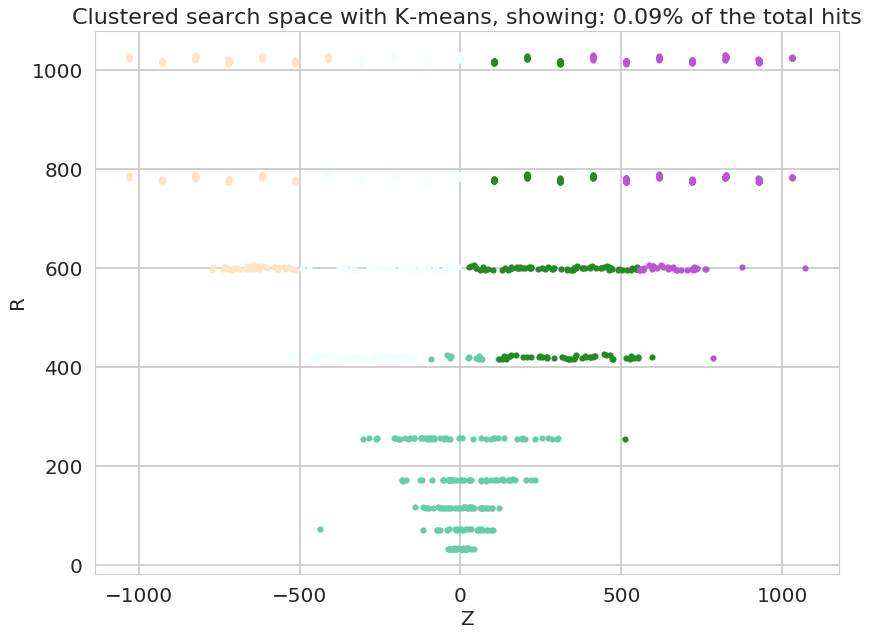

In [16]:
from matplotlib import colors as mcolors # for colors

R_viz = 1000
colors = list(mcolors.CSS4_COLORS.keys())
from_each_reg = R_viz // N_pre_cluster #show only a portion of found regions
fig = plt.figure()

for i in range(N_pre_cluster):
    reg_i = np.random.choice(list(np.where(pre_labels==i)[0]), from_each_reg, replace=False)
    df_plot = data.iloc[reg_i]
    plt.plot(df_plot.z, df_plot.r, ".", c=colors[17+i])
plt.xlabel("Z")
plt.ylabel("R")
percentage = 100 * N_pre_cluster * from_each_reg / len(data.hit_id.values)
plt.title("Clustered search space with K-means, showing: {:.2f}% of the total hits".format(percentage), fontsize=20)
plt.show()


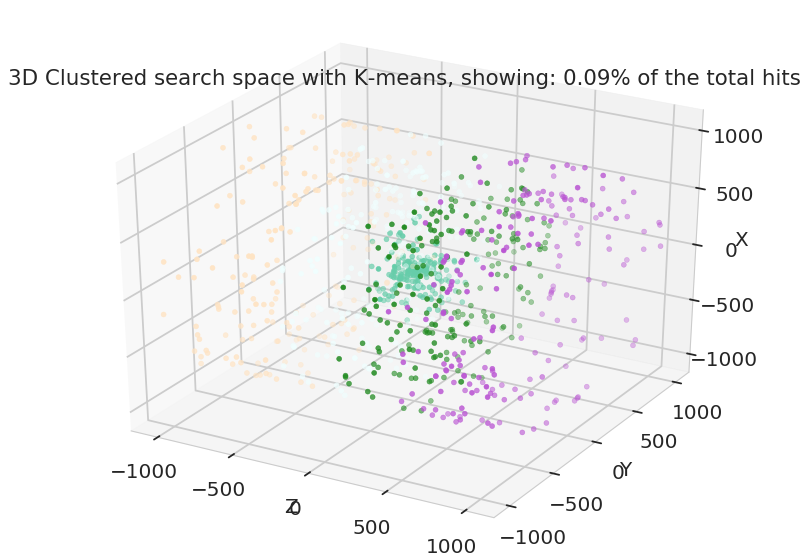

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(N_pre_cluster):
    reg_i = np.random.choice(list(np.where(pre_labels==i)[0]), from_each_reg, replace=False)
    df_plot = data.iloc[reg_i]
    ax.scatter(df_plot.z, df_plot.y, df_plot.x, ".", c=colors[17+i])

ax.set_xlabel('Z')
ax.set_ylabel('Y')
ax.set_zlabel('X')
percentage = 100 * N_pre_cluster * from_each_reg / len(data.hit_id.values)
plt.title("Clustered search space with K-means, showing: {:.2f}% of the total hits".format(percentage))
plt.title("3D Clustered search space with K-means, showing: {:.2f}% of the total hits".format(percentage))
plt.show()


## 3) Clustering one event

Actual pair-wise clustering using a cosine metric. This step produces tracks in each space region and assemble them into global labels.
Depending on the cut distance we choose, the reco tracks will vary. 
##### Smaller distances tend to reduce the size of recovered tracks.

In [18]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster


In [19]:
def cluster_hits2tracks(testX, max_d=0.0001, affinity="cosine"):
    """
    Simple PoC reconstruction algorithm
    """
    Z = linkage(testX, method="complete", metric=affinity)
    clusters = fcluster(Z, max_d, criterion='distance')
    return clusters

** Warning : Next cell requires a lot of memory ** !!

In [20]:
# Warning : requires a lot of memory !!
labels = np.zeros(len(data))
regions = np.unique(pre_labels)
n_regions = len(regions)
for i in regions:
    print( "Reconstructing region {}/{} ...".format(i+1, n_regions), flush=True)
    idx_clus = np.where( pre_labels==i )[0]
    clus = data.ix[ idx_clus, ["x","y","z"] ]
    labels[idx_clus] = cluster_hits2tracks( clus )
tracks = pd.DataFrame(np.column_stack( (range(1,len(labels)+1),labels) ), columns=["hit_id","track_id"]).astype(int)

Reconstructing region 1/5 ...


/home/tao/vestrade/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


MemoryError: 

In [ ]:
T_viz=10
rand_tracks=random.sample(list(np.unique(labels)), T_viz)

fig = plt.figure(figsize=(10,8))
for i in rand_tracks:
    df_plot=df_data.ix[np.where(labels==i)[0]].sort_values(by=['z'])
    plt.plot(df_plot.z,df_plot.r,"-o",c=colors[int(i)%len(colors)],linewidth=0.6)
plt.xlabel("Z")
plt.ylabel("R")
plt.title("Reconstructed tracks, showing: "+str(100*round(T_viz/float(len(np.unique(labels))),3))+"% of the total reco tracks",fontsize=20)
plt.show()


In [ ]:
#3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax = fig.add_subplot(111, projection='3d')
for i in rand_tracks:
    df_plot=df_data.ix[np.where(labels==i)[0]].sort_values(by=['z'])
    ax.scatter(df_plot.z,df_plot.x,df_plot.y,"-o",c=colors[int(i)%len(colors)],linewidth=0.6)
plt.title("3D Reconstructed tracks, showing: "+str(100*round(T_viz/float(len(np.unique(labels))),3))+"% of the total reco tracks",fontsize=20)
ax.set_xlabel('Z',fontsize=15)
ax.set_ylabel('X',fontsize=15)
ax.set_zlabel('Y',fontsize=15)
plt.show()
